In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import huggingface_hub as hf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple
from transformers import AutoTokenizer, AutoModel

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 256)

plt.style.use('seaborn-v0_8')
load_dotenv()
hf.login(os.environ["HF_TOKEN"])
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"], "HF_HOME:", os.environ["HF_HOME"])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /home/mohsenfayyaz/.cache/huggingface/token
Login successful
CUDA_VISIBLE_DEVICES: 7 HF_HOME: /local1/mohsenfayyaz/.hfcache/


# Download Dataset + DecompX Tensors

In [2]:
# DATASET = "re-docred_facebook--contriever-msmarco_7170.pkl"
DATASET = "re-docred_facebook--dragon-plus-query-encoder_7170.pkl"
# DATASET = "re-docred_OpenMatch--cocodr-base-msmarco_7170.pkl.gz"

hf.hf_hub_download(repo_id="Retriever-Contextualization/datasets", filename=f"results/{DATASET}", repo_type="dataset", local_dir="hf/")

'hf/results/re-docred_facebook--dragon-plus-query-encoder_7170.pkl'

In [3]:
df_raw = pd.read_pickle(f"./hf/results/{DATASET}")
print(df_raw.attrs)
df_raw.head(1)

{'model': 'facebook/dragon-plus-query-encoder', 'query_model': 'facebook/dragon-plus-query-encoder', 'context_model': 'facebook/dragon-plus-context-encoder', 'pooling': 'cls', 'dataset': 're-docred', 'corpus_size': 105925, 'eval': {'ndcg': {'NDCG@1': 0.47685, 'NDCG@3': 0.52523, 'NDCG@5': 0.53646, 'NDCG@10': 0.54955, 'NDCG@100': 0.58002, 'NDCG@1000': 0.59556}, 'map': {'MAP@1': 0.47685, 'MAP@3': 0.51341, 'MAP@5': 0.51959, 'MAP@10': 0.52496, 'MAP@100': 0.53058, 'MAP@1000': 0.53109}, 'recall': {'Recall@1': 0.47685, 'Recall@3': 0.55941, 'Recall@5': 0.58689, 'Recall@10': 0.62748, 'Recall@100': 0.77741, 'Recall@1000': 0.90349}, 'precision': {'P@1': 0.47685, 'P@3': 0.18647, 'P@5': 0.11738, 'P@10': 0.06275, 'P@100': 0.00777, 'P@1000': 0.0009}}}


,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled
0,test0,When was Loud Tour published?,[Loud Tour],"{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...","{'len': 1000, 'max': 390.3378601074219, 'min': 377.525390625, 'std': 1.243663421340353, 'mean': 378.77503692626954, 'median': 378.4281463623047}",{'Loud Tour': 390.3378601074219},"{'Loud Tour': 390.3378601074219, 'Loud'n'proud': 385.71905517578125, 'Poetry Bus Tour': 385.4292907714844, 'Live &amp; Loud': 384.18218994140625, 'The Loudest Engine': 384.0265808105469, 'Young Wild Things Tour': 383.8572998046875, 'Guitar Rock Tour': ...","{'Loud Tour': {'text': 'The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the Americas and Europe , the tour was launched in support of Rihanna 's fifth stud...",test0,Loud Tour,"[[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3]...","[{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}, {'r': 'P175', 'h': 0, 't': 2, 'evidence': [0, 1]}, {'r': 'P131', 'h': 10, 't': 8, 'evidence': [4]}, {'r': 'P17', 'h': 8, 't': 7, 'evidence': [3, 4]}, {'r': 'P17', 'h': 10, 't': 7, 'evidence': [3, 4]}, {'...","[[The, Loud, Tour, was, the, fourth, overall, and, third, world, concert, tour, by, Barbadian, recording, artist, Rihanna, .], [Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihan...",test,"{'r': 'P577', 'h': 0, 't': 6, 'evidence': [1]}",0,"[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}, {'name': 'Loud Tour', 'pos': [1, 3], 'sent_id': 6, 'type': 'MISC', 'global_pos': [128, 128], 'index': '0_1'}, {'name': 'Loud Tour', 'pos': [1, 3],...","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]","{Loud, Loud Tour}",{2010},Loud Tour,2010,{MISC},{TIME},[1],"[[Performing, in, over, twenty, countries, in, the, Americas, and, Europe, ,, the, tour, was, launched, in, support, of, Rihanna, 's, fifth, studio, album, Loud, (, 2010, ), .]]","[{'name': 'Loud', 'pos': [23, 24], 'sent_id': 1, 'type': 'MISC', 'global_pos': [41, 41], 'index': '0_0'}]","[{'pos': [25, 26], 'type': 'TIME', 'sent_id': 1, 'name': '2010', 'global_pos': [43, 43], 'index': '6_0'}]",P577,publication date,When was Loud Tour published?,0,{},1.0,"Loud Tour The Loud Tour was the fourth overall and third world concert tour by Barbadian recording artist Rihanna . Performing in over twenty countries in the A

In [14]:
df = df_raw.copy()
df = df[df["evidence_sent_ids"].str.len() == 1]  # 1 Evidence
df = df[df["evidence_sents"].str.len() == 1]  # 1 Evidence Sentence
df = df[df["head_entity_in_evidence"].str.len() == 1]  # 1 Head in Evidence
df = df[df["head_entity_names"].str.len() == 1]  # All heads have the same name
# Filter Repeated Labels (Only 1 h->t)
def not_repeated_label(label, labels):
    repeat_count = 0
    for l in labels:
        if l['h'] == label['h'] and l['t'] == label['t']:
            repeat_count += 1
    return True if repeat_count == 1 else False
df["repeated_label"] = df.apply(lambda r: not_repeated_label(r["label"], r["labels"]), axis=1)
df = df[df["repeated_label"]]
# df = df[df["head_entity"].str.len() == 2]  # 2 Head Entity (1 in evidence, 1 not in evidence)
print(len(df))  # 2239

def flatten(xss):
    return [x for xs in xss for x in xs]

def sentences_w_multiple_heads(head_enitites):
    sents = []
    repeated = []
    for e in head_enitites:
        sents.append(e["sent_id"])
        if sents.count(e["sent_id"]) > 1:
            repeated.append(e["sent_id"])
    return list(set(repeated))

### Find Head in other sentences
head_w_tail_sents = []
head_wo_tail_sents = []
head_wo_tail_entity = []
for row in df.to_dict(orient="records"):
    head_w_tail = " ".join(flatten(row["evidence_sents"]))
    head_wo_tail = None
    sents_w_multiple_heads = sentences_w_multiple_heads(row["head_entity"])
    for head_entity in row["head_entity"]:
        evidence_sent_id = row["evidence_sent_ids"][0]
        if head_entity["sent_id"] != evidence_sent_id and head_entity["sent_id"] not in sents_w_multiple_heads:
            head_wo_tail_ent = head_entity
            head_wo_tail = " ".join(row["sents"][head_entity["sent_id"]])
            break
    if head_wo_tail is None:
        head_w_tail_sents.append(None)
        head_wo_tail_sents.append(None)
        head_wo_tail_entity.append(None)
    else:
        head_w_tail_sents.append(head_w_tail)
        head_wo_tail_sents.append(head_wo_tail)
        head_wo_tail_entity.append(head_wo_tail_ent)
    
df["head_w_tail_sentence"] = head_w_tail_sents
df["head_wo_tail_sentence"] = head_wo_tail_sents
df["head_wo_tail_entity"] = head_wo_tail_entity
df = df.dropna(subset=["head_w_tail_sentence", "head_wo_tail_sentence"])
print(len(df))

### FILTER NOT SAME POS ENTITY {
df["head_wo_tail_entity_pos"] = df["head_wo_tail_entity"].apply(lambda x: x["pos"][0])
df["head_w_tail_entity_pos"] = df["head_entity_in_evidence"].apply(lambda x: x[0]["pos"][0])
df = df[df["head_wo_tail_entity_pos"] == df["head_w_tail_entity_pos"]]
print(len(df))
### }

df["head_wo_tail_sentence_double"] = df["head_wo_tail_sentence"] + " " + df["head_wo_tail_sentence"]
df["head_w_tail_sentence_double"] = df["head_w_tail_sentence"] + " " + df["head_w_tail_sentence"]
df["head_wo_tail_sentence_title"] = df.apply(lambda r: r["head_entity_in_evidence"][0]["name"] + " " + r["head_entity_in_evidence"][0]["name"] + " " + r["head_entity_in_evidence"][0]["name"] + " " + r["head_wo_tail_sentence"], axis=1)
df["sents_complete"] = df["sents"].apply(lambda x: " ".join(flatten(x)))
df["sents_complete_rm_head_wo_tail"] = df.apply(lambda r: r["sents_complete"].replace(r["head_wo_tail_sentence"], ""), axis=1)
df["sents_complete_rm_head_w_tail"] = df.apply(lambda r: r["sents_complete"].replace(r["head_w_tail_sentence"], ""), axis=1)
# Put the w and wo sentence in the beginning
df["sents_complete_w_beginning"] = df.apply(lambda r: r["head_w_tail_sentence"] + " " + r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], ""), axis=1)
df["sents_complete_wo_beginning"] = df.apply(lambda r: r["head_wo_tail_sentence"] + " " + r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], ""), axis=1)
# Put the w and wo sentence in the end
df["sents_complete_w_end"] = df.apply(lambda r: r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], "") + " " + r["head_w_tail_sentence"] , axis=1)
df["sents_complete_wo_end"] = df.apply(lambda r: r["sents_complete"].replace(r["head_wo_tail_sentence"], "").replace(r["head_w_tail_sentence"], "") + " " + r["head_wo_tail_sentence"], axis=1)

d = df.iloc[0].to_dict()
print(d["query"])
print(d["tail_entity_in_evidence"])
print(d["head_entity_in_evidence"])
for i, d in enumerate(d["sents"]): print(i, d)

df[["query", "head_w_tail_sentence", "head_wo_tail_sentence", "head_entity_in_evidence", "head_wo_tail_entity", "sents_complete", "sents_complete_rm_head_wo_tail", "sents_complete_rm_head_w_tail"]].sample(3)

1508
257
85
Which administrative territorial entity is Latourell Falls located in?
[{'name': 'Oregon', 'pos': [15, 16], 'sent_id': 0, 'type': 'LOC', 'global_pos': [15, 15], 'index': '3_0'}]
[{'name': 'Latourell Falls', 'pos': [0, 2], 'sent_id': 0, 'type': 'LOC', 'global_pos': [0, 0], 'index': '0_0'}]
0 ['Latourell', 'Falls', 'is', 'a', 'waterfall', 'along', 'the', 'Columbia', 'River', 'Gorge', 'in', 'the', 'U.S.', 'state', 'of', 'Oregon', ',', 'within', 'Guy', 'W.', 'Talbot', 'State', 'Park', '.']
1 ['The', 'Historic', 'Columbia', 'River', 'Highway', 'passes', 'nearby', ',', 'and', 'at', 'certain', 'locations', 'the', 'Lower', 'falls', 'are', 'visible', 'from', 'the', 'road', '.']
2 ['Near', 'the', 'base', 'of', 'the', 'falls', ',', 'a', 'parking', 'lot', 'and', 'path', 'were', 'erected', 'to', 'assist', 'visitors', 'to', 'the', 'site', '.']
3 ['Visitors', 'must', 'hike', 'along', 'the', 'loop', 'trail', 'to', 'see', 'the', 'upper', 'falls', '.']
4 ['Latourell', 'is', 'unique', 'among'

,query,head_w_tail_sentence,head_wo_tail_sentence,head_entity_in_evidence,head_wo_tail_entity,sents_complete,sents_complete_rm_head_wo_tail,sents_complete_rm_head_w_tail
6586,Where is Yandina located on a terrain feature?,"Yandina is a town on Mbanika Island in the Russell Islands , in the Central Province of Solomon Islands .","Yandina is the site of a copra and cocoa plantation and has basic services such as a store , post office , and rest house .","[{'name': 'Yandina', 'pos': [0, 1], 'sent_id': 0, 'type': 'LOC', 'global_pos': [0, 0], 'index': '0_1'}]","{'name': 'Yandina', 'pos': [0, 1], 'sent_id': 2, 'type': 'LOC', 'global_pos': [40, 40], 'index': '0_0'}","Yandina is a town on Mbanika Island in the Russell Islands , in the Central Province of Solomon Islands . It is a port , and an airport ( ICAO code : AGGY , IATA code : XYA ) . Yandina is the site of a copra and cocoa plantation and has basic services ...","Yandina is a town on Mbanika Island in the Russell Islands , in the Central Province of Solomon Islands . It is a port , and an airport ( ICAO code : AGGY , IATA code : XYA ) . The Yandina police station was the scene of one of the opening events of t...","It is a port , and an airport ( ICAO code : AGGY , IATA code : XYA ) . Yandina is the site of a copra and cocoa plantation and has basic services such as a store , post office , and rest house . The Yandina police station was the scene of one of the o..."
5026,When was Tivadar Puskás born?,"Tivadar Puskás ( politician ) ( 1952- ) , Hungarian politician","Tivadar Puskás ( 1844 – 1893 ) , Hungarian inventor of the telephone exchange","[{'name': 'Tivadar Puskás', 'pos': [0, 2], 'sent_id': 9, 'type': 'PER', 'global_pos': [127, 127], 'index': '14_1'}]","{'name': 'Tivadar Puskás', 'pos': [0, 2], 'sent_id': 8, 'type': 'PER', 'global_pos': [113, 113], 'index': '14_0'}","Puskás is a Hungarian surname . Notable people with the surname include : Ferenc Puskás ( 1927 – 2006 ) , Hungarian football player and manager FIFA Puskás Award , the player judged to have scored the most aesthetically significant and "" most beautiful...","Puskás is a Hungarian surname . Notable people with the surname include : Ferenc Puskás ( 1927 – 2006 ) , Hungarian football player and manager FIFA Puskás Award , the player judged to have scored the most aesthetically significant and "" most beautiful...","Puskás is a Hungarian surname . Notable people with the surname include : Ferenc Puskás ( 1927 – 2006 ) , Hungarian football player and manager FIFA Puskás Award , the player judged to have scored the most aesthetically significant and "" most beautiful..."
297,Who is the publisher of Assassin 's Creed Unity?,Assassin 's Creed Unity is an action - adventure video game developed by Ubisoft Montreal and published by Ubisoft .,Assassin 's Creed Unity received mixed reviews upon its release .,"[{'type': 'MISC', 'pos': [0, 4], 'name': 'Assassin 's Creed Unity', 'sent_id': 0, 'global_pos': [0, 0], 'index': '0_0'}]","{'type': 'MISC', 'pos': [0, 4], 'name': 'Assassin 's Creed Unity', 'sent_id': 8, 'global_pos': [214, 214], 'index': '0_1'}","Assassin 's Creed Unity is an action - adventure video game developed by Ubisoft Montreal and published by Ubisoft . It was released in November 2014 for Microsoft Windows , PlayStation 4 and Xbox One . It is the eighth major installment in the Assassi...","Assassin 's Creed Unity is an action - adventure video game developed by Ubisoft Montreal and published by Ubisoft . It was released in November 2014 for Microsoft Windows , PlayStation 4 and Xbox One . It is the eighth major installment in the Assassi...","It was released in November 2014 for Microsoft Windows , PlayStation 4 and Xbox One . It is the eighth major installment in the Assassin 's Creed series , and the successor to 2013 's . It also has ties to Assassin 's Creed Rogue which was released fo..."


In [15]:
class YourCustomDEModel:
    def __init__(self, q_model, doc_model, pooling, sep: str = " ", **kwargs):
        self.tokenizer = AutoTokenizer.from_pretrained(q_model)
        self.query_encoder = AutoModel.from_pretrained(q_model)
        self.context_encoder = AutoModel.from_pretrained(doc_model)
        self.pooling = pooling
        self.sep = sep
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Write your own encoding query function (Returns: Query embeddings as numpy array)
    def encode_queries(self, queries: List[str], batch_size=32, **kwargs) -> np.ndarray:
        print("Q")
        print(len(queries))
        return self.encode_in_batch(self.query_encoder, queries, batch_size)
    
    # Write your own encoding corpus function (Returns: Document embeddings as numpy array)  
    def encode_corpus(self, corpus: List[Dict[str, str]], batch_size=32, **kwargs) -> np.ndarray:
        if type(corpus) is dict:
            sentences = [(corpus["title"][i] + self.sep + corpus["text"][i]).strip() if "title" in corpus else corpus["text"][i].strip() for i in range(len(corpus['text']))]
        else:
            sentences = [(doc["title"] + self.sep + doc["text"]).strip() if "title" in doc else doc["text"].strip() for doc in corpus]
        return self.encode_in_batch(self.context_encoder, sentences, batch_size)

    def encode_in_batch(self, model, sentences: List[str], batch_size=32, **kwargs) -> np.ndarray:
        model.to(self.device)
        all_embeddings = []
        for batch in tqdm(torch.utils.data.DataLoader(sentences, batch_size=batch_size, shuffle=False)):
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors='pt', max_length=512)
            inputs = {key: val.to(self.device) for key, val in inputs.items()}
            outputs = model(**inputs)
            ### POOLING
            if self.pooling == "avg":
                embeddings = self.mean_pooling(outputs[0], inputs['attention_mask'])
            elif self.pooling == "cls":
                embeddings = outputs.last_hidden_state[:, 0, :]  # [128, 768] = [batch, emb_dim]
            else:
                raise ValueError("Pooling method not supported")
            all_embeddings.extend(embeddings.detach().cpu().numpy())
        all_embeddings = np.array(all_embeddings)
        print(all_embeddings.shape)
        return all_embeddings

    def mean_pooling(self, token_embeddings, mask):
        token_embeddings = token_embeddings.masked_fill(~mask[..., None].bool(), 0.)
        sentence_embeddings = token_embeddings.sum(dim=1) / mask.sum(dim=1)[..., None]
        return sentence_embeddings

Q
85


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
head_w_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
head_wo_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_rm_head_wo_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_rm_head_w_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_w_beginning_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_wo_beginning_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_w_end_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_wo_end_dot
w_tail_greater
True     72
False    13
Name: count, dtype: int64
w_tail_greater_beginning
True     67
False    18
Name: count, dtype: int64
w_tail_greater_end
True     66
False    19
Name: count, dtype: int64
facebook/dragon-plus-query-encoder head_w_tail_dot TtestResult(statistic=np.float64(8.617537724183357), pvalue=np.float64(3.492922151799054e-13), df=np.int64(84))
facebook/dragon-plus-query-encoder sents_complete_w_beginning_dot TtestResult(statistic=np.float64(5.147140844410103), pvalue=np.float64(1.711954486368747e-06), df=np.int64(84))
facebook/dragon-plus-query-encoder sents_complete_w_end_dot TtestResult(statistic=np.float64(4.793591144517985), pvalue=np.float64(6.997080537940606e-06), df=np.int64(84))


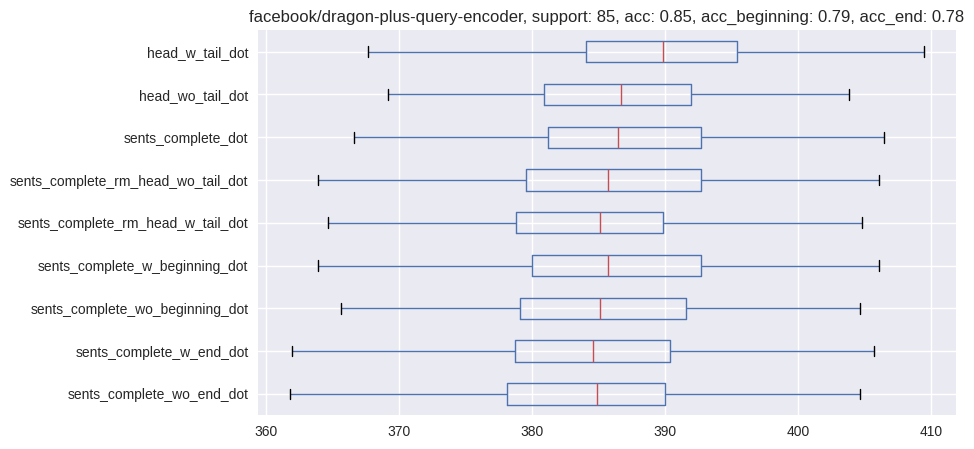

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Q
85


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
head_w_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
head_wo_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_rm_head_wo_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_rm_head_w_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_w_beginning_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_wo_beginning_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_w_end_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_wo_end_dot
w_tail_greater
True     55
False    30
Name: count, dtype: int64
w_tail_greater_beginning
True     68
False    17
Name: count, dtype: int64
w_tail_greater_end
True     59
False    26
Name: count, dtype: int64
facebook/contriever-msmarco head_w_tail_dot TtestResult(statistic=np.float64(3.617585323159467), pvalue=np.float64(0.0005066453226293648), df=np.int64(84))
facebook/contriever-msmarco sents_complete_w_beginning_dot TtestResult(statistic=np.float64(5.347929830312182), pvalue=np.float64(7.540328288363926e-07), df=np.int64(84))
facebook/contriever-msmarco sents_complete_w_end_dot TtestResult(statistic=np.float64(2.452640056649596), pvalue=np.float64(0.016250779349064805), df=np.int64(84))


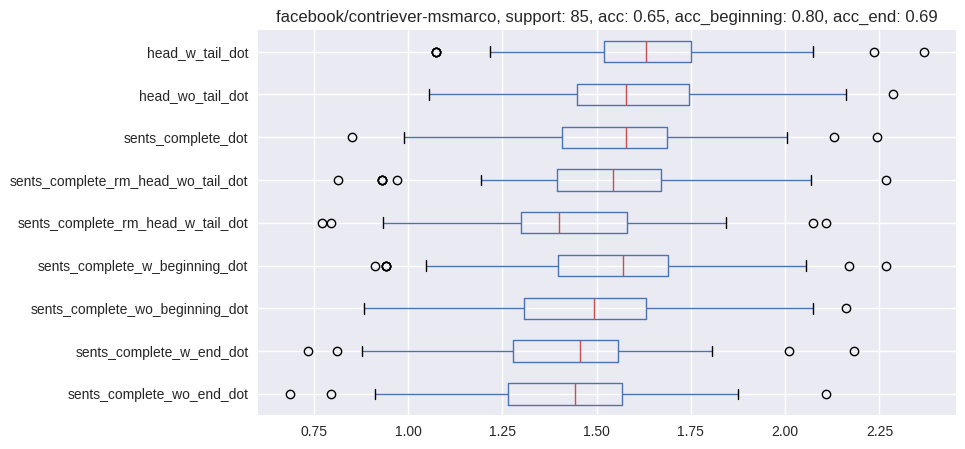

Q
85


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
head_w_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
head_wo_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_rm_head_wo_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_rm_head_w_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_w_beginning_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_wo_beginning_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_w_end_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_wo_end_dot
w_tail_greater
True     71
False    14
Name: count, dtype: int64
w_tail_greater_beginning
True     68
False    17
Name: count, dtype: int64
w_tail_greater_end
True     54
False    31
Name: count, dtype: int64
OpenMatch/cocodr-base-msmarco head_w_tail_dot TtestResult(statistic=np.float64(7.8314488184643665), pvalue=np.float64(1.3176134132915274e-11), df=np.int64(84))
OpenMatch/cocodr-base-msmarco sents_complete_w_beginning_dot TtestResult(statistic=np.float64(5.84329650723324), pvalue=np.float64(9.436714503882054e-08), df=np.int64(84))
OpenMatch/cocodr-base-msmarco sents_complete_w_end_dot TtestResult(statistic=np.float64(4.3398206761061475), pvalue=np.float64(3.952572564083246e-05), df=np.int64(84))


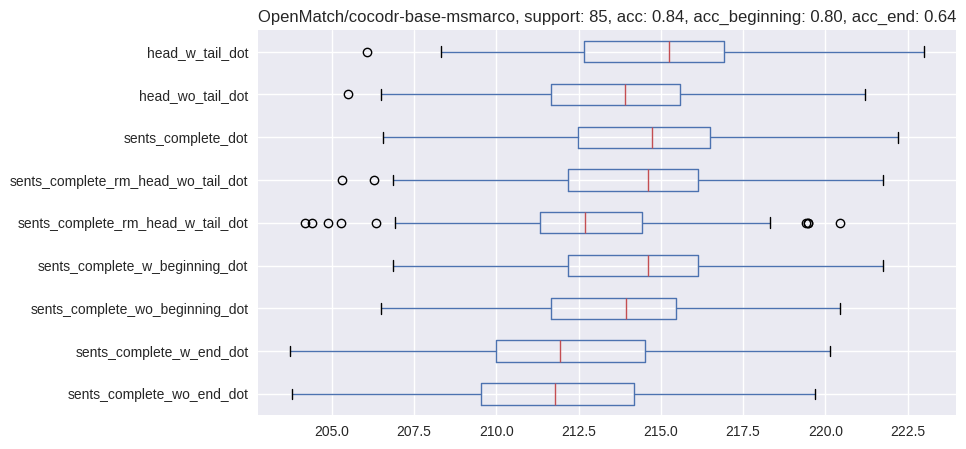

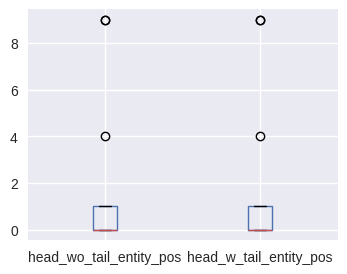

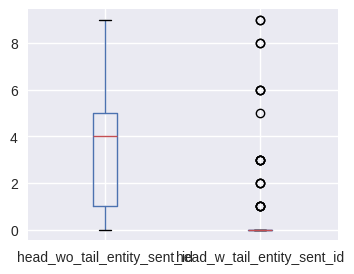

,query_model,context_model,POOLING,support,sents_complete_w_beginning_dot_vs_wo,sents_complete_w_end_dot_vs_wo,head_w_tail_dot_vs_wo,sents_complete_rm_wo_dot_vs_w
0,facebook/dragon-plus-query-encoder,facebook/dragon-plus-context-encoder,cls,85,"(5.147140844410103, 1.711954486368747e-06)","(4.793591144517985, 6.997080537940606e-06)","(8.617537724183357, 3.492922151799054e-13)","(4.916360655117166, 4.314937817014082e-06)"
1,facebook/contriever-msmarco,facebook/contriever-msmarco,avg,85,"(5.347929830312182, 7.540328288363926e-07)","(2.452640056649596, 0.016250779349064805)","(3.617585323159467, 0.0005066453226293648)","(6.833198386432631, 1.2317846976322653e-09)"
2,OpenMatch/cocodr-base-msmarco,OpenMatch/cocodr-base-msmarco,cls,85,"(5.84329650723324, 9.436714503882054e-08)","(4.3398206761061475, 3.952572564083246e-05)","(7.8314488184643665, 1.3176134132915274e-11)","(7.979289066076732, 6.673129757653097e-12)"


In [16]:
cfgs = [
    ("facebook/dragon-plus-query-encoder", "facebook/dragon-plus-context-encoder", "cls"),
    ("facebook/contriever-msmarco", "facebook/contriever-msmarco", "avg"),
    ("OpenMatch/cocodr-base-msmarco", "OpenMatch/cocodr-base-msmarco", "cls"),
]
plot_cols = [
    "head_w_tail_sentence", "head_wo_tail_sentence", "sents_complete", "sents_complete_rm_head_wo_tail", "sents_complete_rm_head_w_tail",
    "sents_complete_w_beginning", "sents_complete_wo_beginning", "sents_complete_w_end", "sents_complete_wo_end",
]

results = []
for query_model, context_model, POOLING in cfgs:
    dpr = YourCustomDEModel(query_model, context_model, POOLING)
    def to_doc_format(sentences: list):
        return [{"text": s} for s in sentences]
    query_embds = dpr.encode_queries(df["query"].to_list())
    plot_col_dots = []
    for col in plot_cols:
        embds = dpr.encode_corpus(to_doc_format(df[col].to_list()))
        embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds))
        new_col = f"{col.replace('_sentence', '')}_dot"
        print(new_col)
        df[new_col] = embds_dot.cpu().numpy()
        plot_col_dots.append(new_col)
    df["w_tail_greater"] = df["head_w_tail_dot"] > df["head_wo_tail_dot"]
    df["w_tail_greater_beginning"] = df["sents_complete_w_beginning_dot"] > df["sents_complete_wo_beginning_dot"]
    df["w_tail_greater_end"] = df["sents_complete_w_end_dot"] > df["sents_complete_wo_end_dot"]
    # df["w_tail_greater"] = df["sents_complete_rm_head_wo_tail"] > df["sents_complete_rm_head_w_tail"]
    print(df["w_tail_greater"].value_counts())
    print(df["w_tail_greater_beginning"].value_counts())
    print(df["w_tail_greater_end"].value_counts())
    
    print(query_model, "head_w_tail_dot", stats.ttest_rel(df["head_w_tail_dot"], df["head_wo_tail_dot"]))
    print(query_model, "sents_complete_w_beginning_dot", stats.ttest_rel(df["sents_complete_w_beginning_dot"], df["sents_complete_wo_beginning_dot"]))
    print(query_model, "sents_complete_w_end_dot", stats.ttest_rel(df["sents_complete_w_end_dot"], df["sents_complete_wo_end_dot"]))
    results.append({
        "query_model": query_model,
        "context_model": context_model,
        "POOLING": POOLING,
        "support": len(df),
        "sents_complete_w_beginning_dot_vs_wo": stats.ttest_rel(df["sents_complete_w_beginning_dot"], df["sents_complete_wo_beginning_dot"]),
        "sents_complete_w_end_dot_vs_wo": stats.ttest_rel(df["sents_complete_w_end_dot"], df["sents_complete_wo_end_dot"]),
        "head_w_tail_dot_vs_wo": stats.ttest_rel(df["head_w_tail_dot"], df["head_wo_tail_dot"]),
        "sents_complete_rm_wo_dot_vs_w": stats.ttest_rel(df["sents_complete_rm_head_wo_tail_dot"], df["sents_complete_rm_head_w_tail_dot"]),
    })
    
    df[plot_col_dots[::-1]].boxplot(figsize=(9, 5), rot=0, vert=False)
    plt.title(f"{query_model}, support: {len(df)}, acc: {df['w_tail_greater'].mean():.2f}, acc_beginning: {df['w_tail_greater_beginning'].mean():.2f}, acc_end: {df['w_tail_greater_end'].mean():.2f}")
    plt.show()

### POS IN SENTENCE BOXPLOT
df["head_wo_tail_entity_pos"] = df["head_wo_tail_entity"].apply(lambda x: x["pos"][0])
df["head_w_tail_entity_pos"] = df["head_entity_in_evidence"].apply(lambda x: x[0]["pos"][0])
df[["head_wo_tail_entity_pos", "head_w_tail_entity_pos"]].boxplot(figsize=(4, 3))
plt.show()


### SENTENCE POS BOXPLOT
df["head_wo_tail_entity_sent_id"] = df["head_wo_tail_entity"].apply(lambda x: x["sent_id"])
df["head_w_tail_entity_sent_id"] = df["head_entity_in_evidence"].apply(lambda x: x[0]["sent_id"])
df[["head_wo_tail_entity_sent_id", "head_w_tail_entity_sent_id"]].boxplot(figsize=(4, 3))
plt.show()

rdf = pd.DataFrame(results)
rdf

In [10]:
df.loc[[4949]]

,query_id,query,gold_docs,gold_docs_text,scores_stats,scores_gold,scores_1000,predicted_docs_text_10,id,title,vertexSet,labels,sents,split,label,label_idx,head_entity,tail_entity,head_entity_names,tail_entity_names,head_entity_longest_name,tail_entity_longest_name,head_entity_types,tail_entity_types,evidence_sent_ids,evidence_sents,head_entity_in_evidence,tail_entity_in_evidence,relation,relation_name,query_question,duplicate_titles_len,duplicate_titles,hit_rank,gold_doc,gold_doc_title,gold_doc_text,gold_doc_score,pred_doc,pred_doc_title,pred_doc_text,pred_doc_score,gold_doc_len,pred_doc_len,query_decompx_tokens,query_decompx_tokenizer_word_ids,query_decompx_cls_or_mean_pooled,query_decompx_tokens_dot_scores,query_decompx_decompx_last_layer_pooled,gold_doc_decompx_tokens,gold_doc_decompx_tokenizer_word_ids,gold_doc_decompx_cls_or_mean_pooled,gold_doc_decompx_tokens_dot_scores,gold_doc_decompx_decompx_last_layer_pooled,pred_doc_decompx_tokens,pred_doc_decompx_tokenizer_word_ids,pred_doc_decompx_cls_or_mean_pooled,pred_doc_decompx_tokens_dot_scores,pred_doc_decompx_decompx_last_layer_pooled,repeated_label,head_w_tail_sentence,head_wo_tail_sentence,head_wo_tail_entity,head_wo_tail_sentence_double,head_w_tail_sentence_double,head_wo_tail_sentence_title,sents_complete,sents_complete_rm_head_wo_tail,sents_complete_rm_head_w_tail,sents_complete_w_beginning,sents_complete_wo_beginning,sents_complete_w_end,sents_complete_wo_end,head_w_tail_dot,head_wo_tail_dot,sents_complete_dot,sents_complete_rm_head_wo_tail_dot,sents_complete_rm_head_w_tail_dot,sents_complete_w_beginning_dot,sents_complete_wo_beginning_dot,sents_complete_w_end_dot,sents_complete_wo_end_dot,w_tail_greater,w_tail_greater_beginning,w_tail_greater_end,head_wo_tail_entity_pos,head_w_tail_entity_pos,head_wo_tail_entity_sent_id,head_w_tail_entity_sent_id
4949,validation5785,When was Dynamite Warrior published?,[Dan Chupong],"{'Dan Chupong': {'text': 'Chupong Changprung ( Thai ; ชูพงษ์ ช่างปรุง ; RTGS : Dan Chupong ) ; born March 23 , 1981 in Kalasin Province , Thailand , Thai nickname : "" Deaw "" เดี่ยว is a Thai martial arts film actor . He is also known by his Westernized...","{'len': 1000, 'max': 388.104736328125, 'min': 380.3094482421875, 'std': 1.1545616237361775, 'mean': 381.518169921875, 'median': 381.2028045654297}",{'Dan Chupong': 383.4316711425781},"{'Dynamite Headdy': 388.104736328125, 'Black Dynamite': 387.6751708984375, 'Baby You're Dynamite': 387.6229553222656, 'The Warriors (video game)': 387.316162109375, 'Freddy vs. Jason vs. Ash: The Nightmare Warriors': 387.193603515625, 'Hyrule Warriors'...",{'Dynamite Headdy': {'text': 'Dynamite Headdy is a platform video game developed by Treasure and published by Sega for the Sega Genesis in 1994 . The game follows a puppet named Headdy in his efforts to stop an evil puppet king from taking over his wor...,validation5785,Dan Chupong,"[[{'name': 'Chupong Changprung', 'pos': [0, 2], 'sent_id': 0, 'type': 'PER', 'global_pos': [0, 0], 'index': '0_0'}, {'name': 'Dan Chupong', 'pos': [10, 12], 'sent_id': 0, 'type': 'PER', 'global_pos': [10, 10], 'index': '0_1'}, {'name': 'Dan Chupong', '...","[{'r': 'P569', 'h': 0, 't': 2, 'evidence': [0]}, {'r': 'P19', 'h': 0, 't': 3, 'evidence': [0]}, {'r': 'P27', 'h': 0, 't': 4, 'evidence': [0]}, {'r': 'P69', 'h': 0, 't': 19, 'evidence': [0, 5]}, {'r': 'P131', 'h': 3, 't': 4, 'evidence': [0]}, {'r': 'P17...","[[Chupong, Changprung, (, Thai, ;, ชูพงษ์, ช่างปรุง, ;, RTGS, :, Dan, Chupong, ), ;, born, March, 23, ,, 1981, in, Kalasin, Province, ,, Thailand, ,, Thai, nickname, :, "", Deaw, "", เดี่ยว, is, a, Thai, martial, arts, film, actor, .], [He, is, also, kno...",validation,"{'r': 'P577', 'h': 12, 't': 11, 'evidence': [3]}",25,"[{'name': 'Dynamite Warrior', 'pos': [18, 20], 'sent_id': 3, 'type': 'MISC', 'global_pos': [118, 118], 'index': '12_0'}, {'name': 'Dynamite Warrior', 'pos': [10, 12], 'sent_id': 7, 'type': 'MISC', 'global_pos': [198, 198], 'index': '12_1'}]","[{'pos': [16, 17], '

In [16]:
stats.ttest_rel(df["head_w_tail_dot"], df["head_wo_tail_dot"])
# stats.ttest_rel(df["sents_complete_w_beginning_dot"], df["sents_complete_wo_beginning_dot"])
stats.ttest_rel(df["sents_complete_w_end_dot"], df["sents_complete_wo_end_dot"])

TtestResult(statistic=np.float64(4.340799330942229), pvalue=np.float64(2.0458953334905114e-05), df=np.int64(256))

In [7]:
### DRAGON
# query_model = "facebook/dragon-plus-query-encoder"
# context_model = "facebook/dragon-plus-context-encoder"
# POOLING = "cls"

### CONTRIEVER
query_model = "facebook/contriever-msmarco"
context_model = "facebook/contriever-msmarco"
POOLING = "avg"

### COCODR
# query_model = "OpenMatch/cocodr-base-msmarco"
# context_model = "OpenMatch/cocodr-base-msmarco"
# POOLING = "cls"

dpr = YourCustomDEModel(query_model, context_model, POOLING)

/data2/mohsenfayyaz/anaconda3/envs/mohsen-env/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [123]:
def to_doc_format(sentences: list):
    return [{"text": s} for s in sentences]

query_embds = dpr.encode_queries(df["query"].to_list())
# query_embds = dpr.encode_queries(df["head_entity_in_evidence"].apply(lambda x: x[0]["name"]).to_list())
# query_embds = dpr.encode_queries(df["head_entity_longest_name"].to_list())

for col in ["head_w_tail_sentence", "head_wo_tail_sentence", "sents_complete", "sents_complete_rm_head_wo_tail", "sents_complete_rm_head_w_tail"]:
    embds = dpr.encode_corpus(to_doc_format(df[col].to_list()))
    embds_dot = torch.einsum("bd,bd->b", torch.tensor(query_embds), torch.tensor(embds))
    new_col = f"{col.replace('_sentence', '')}_dot"
    print(new_col)
    df[new_col] = embds_dot.cpu().numpy()

Q
85


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
head_w_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
head_wo_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_rm_head_wo_tail_dot


  0%|          | 0/3 [00:00<?, ?it/s]

(85, 768)
sents_complete_rm_head_w_tail_dot


w_tail_greater
True     55
False    30
Name: count, dtype: int64


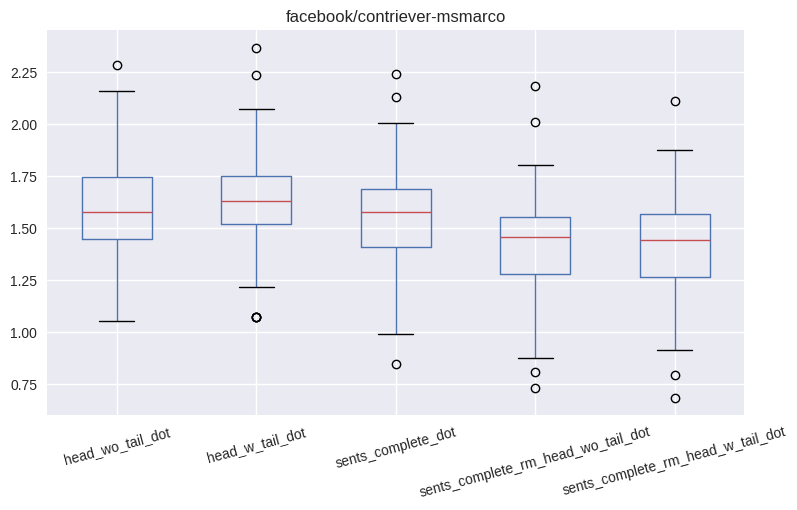

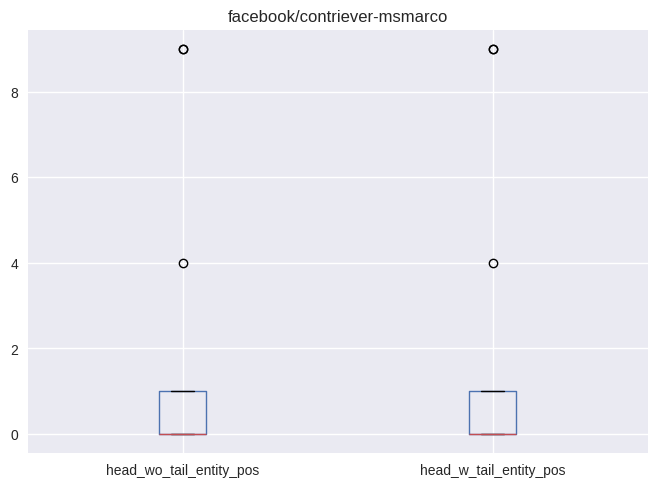

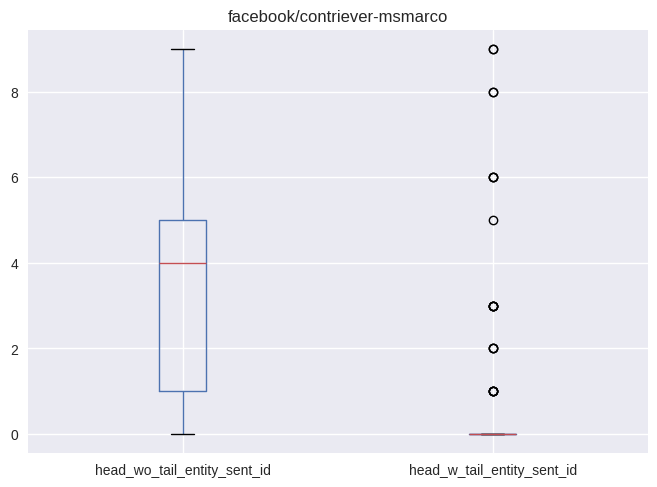

In [99]:
df["w_tail_greater"] = df["head_w_tail_dot"] > df["head_wo_tail_dot"]
print(df["w_tail_greater"].value_counts())

df[[
    # "head_wo_tail_double_dot", "head_w_tail_double_dot",
    "head_wo_tail_dot", "head_w_tail_dot", 
    "sents_complete_dot", "sents_complete_rm_head_wo_tail_dot", "sents_complete_rm_head_w_tail_dot",
    # "head_wo_tail_title_dot",
]].boxplot(figsize=(9, 5), rot=15)
plt.title(query_model)
plt.show()


### POS IN SENTENCE BOXPLOT
df["head_wo_tail_entity_pos"] = df["head_wo_tail_entity"].apply(lambda x: x["pos"][0])
df["head_w_tail_entity_pos"] = df["head_entity_in_evidence"].apply(lambda x: x[0]["pos"][0])
df[["head_wo_tail_entity_pos", "head_w_tail_entity_pos"]].boxplot()
plt.title(query_model)
plt.show()


### SENTENCE POS BOXPLOT
df["head_wo_tail_entity_sent_id"] = df["head_wo_tail_entity"].apply(lambda x: x["sent_id"])
df["head_w_tail_entity_sent_id"] = df["head_entity_in_evidence"].apply(lambda x: x[0]["sent_id"])
df[["head_wo_tail_entity_sent_id", "head_w_tail_entity_sent_id"]].boxplot()
plt.title(query_model)
plt.show()

# df["pos_diff"] = df.apply(lambda r: r["head_w_tail_entity_pos"] - r["head_wo_tail_entity_pos"], axis=1)
# df["pos_diff_abs"] = df["pos_diff"].abs()
# df[["pos_diff_abs"]].boxplot()
# plt.show()

# df2 = df[df["pos_diff_abs"] < 1]
# df2[["head_wo_tail_dot", "head_w_tail_dot"]].boxplot()
# plt.title(query_model)
# plt.show()

In [152]:
df["tail_entity_types"].value_counts()

tail_entity_types
{LOC}     185
{TIME}     76
{MISC}     61
{ORG}      56
{PER}      42
Name: count, dtype: int64

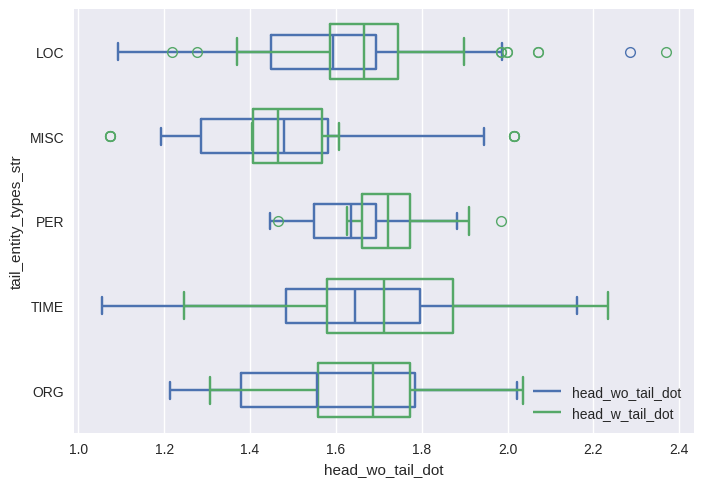

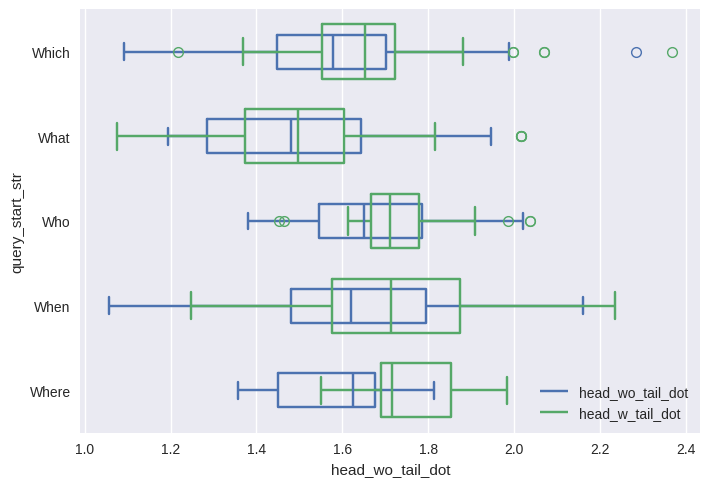

In [62]:
df["tail_entity_types_str"] = df["tail_entity_types"].apply(lambda x: "".join(x))
sns.boxplot(df, y="tail_entity_types_str", x="head_wo_tail_dot", label="head_wo_tail_dot", fill=False, gap=0.5)
sns.boxplot(df, y="tail_entity_types_str", x="head_w_tail_dot", label="head_w_tail_dot", fill=False, gap=0.2)
plt.show()

df["query_start_str"] = df["query"].apply(lambda x: x.split(" ")[0])
sns.boxplot(df, y="query_start_str", x="head_wo_tail_dot", label="head_wo_tail_dot", fill=False, gap=0.5)
sns.boxplot(df, y="query_start_str", x="head_w_tail_dot", label="head_w_tail_dot", fill=False, gap=0.2)
plt.show()

In [83]:
df["w_wo_diff"] = df["head_w_tail_dot"] - df["head_wo_tail_dot"]
df[["query", "head_w_tail_sentence", "head_wo_tail_sentence", "head_wo_tail_dot", "head_w_tail_dot", "w_wo_diff"]].sort_values("w_wo_diff", ascending=False)

,query,head_w_tail_sentence,head_wo_tail_sentence,head_wo_tail_dot,head_w_tail_dot,w_wo_diff
7090,Which administrative territorial entity is Cimatti located in?,"Cimatti was an Italian manufacturer of bicycles , motorcycles and mopeds active between 1937 and 1984 .",Cimatti used two - stroke engines bought from both Moto Morini and Moto Minarelli .,208.200577,213.224197,5.023621
3121,Which administrative territorial entity is Samarinda located in?,Samarinda is the capital of the Indonesian province of East Kalimantan on the island of Borneo .,"Samarinda is known for its traditional food amplang , as well as the cloth sarung samarinda .",211.693710,216.686523,4.992813
6023,When was Chesapeake founded?,"Additionally , Amtrak operated a commuter service named the Chesapeake between 1978 – 1983 .",The Penn Line became the replacement for Amtrak 's Chesapeake as well as the minimal former PRR commuter service between Washington and Baltimore .,206.513306,211.340012,4.826706
2845,Where is the headquarters of Bloomberg L.P. located?,"Bloomberg L.P. is a privately held financial , software , data , and media company headquartered in Midtown Manhattan , New York City .","Bloomberg L.P. also includes a wire service ( Bloomberg News ) , a global television network ( Bloomberg Television ) , digital websites , radio stations ( Bloomberg Radio ) , subscription - only newsletters , and two magazines : Bloomberg Businessweek...",211.697250,216.224899,4.527649
2839,Where is the headquarters of Bloomberg L.P. located?,"Bloomberg L.P. is a privately held financial , software , data , and media company headquartered in Midtown Manhattan , New York City .","Bloomberg L.P. also includes a wire service ( Bloomberg News ) , a global television network ( Bloomberg Television ) , digital websites , radio stations ( Bloomberg Radio ) , subscription - only newsletters , and two magazines : Bloomberg Businessweek...",211.697250,216.224899,4.527649
...,...,...,...,...,...,...
5028,When did Tivadar Puskás die?,"Tivadar Puskás ( 1844 – 1893 ) , Hungarian inventor of the telephone exchange","Tivadar Puskás ( politician ) ( 1952- ) , Hungarian politician",217.696426,216.571350,-1.125076
6021,Who operates Penn Line?,"The Penn Line is a MARC commuter rail service running from Union Station in Washington , D.C. to Perryville , Maryland via Baltimore 's Penn Station on Amtrak 's Northeast Corridor .","The Penn Line is the successor to commuter services provided by the Pennsylvania Railroad ( PRR ) , Penn Central , and Conrail as long ago as the mid-19th century .",213.939926,212.730881,-1.209045
809,When was Heinrich LXXII born?,"Heinrich LXXII , Prince Reuss of Lobenstein and Ebersdorf ( 27 March 1797–17 February 1853 ) was the ruling prince of Reuss - Lobenstein from 7 May 1824 until his abdication on 1 October 1848 , and of Reuss - Ebersdorf from 1822 to 1848 .","Heinrich LXXII abdicated in 1848 , due to civil unrest in connection with the revolutions that spread through Germany and elsewhere in Europe that year .",214.445541,212.881790,-1.563751
5027,When was Tivadar Puskás born?,"Tivadar Puskás ( 1844 – 1893 ) , Hungarian inventor of the telephone exchange","Tivadar Puskás ( politician ) ( 1952- ) , Hungarian politician",219.762329,217.757797,-2.004532


In [40]:
df[["tail_entity_types_str", "query_start_str"]].value_counts().reset_index()

,tail_entity_types_str,query_start_str,count
0,LOC,Which,147
1,TIME,When,73
2,MISC,What,58
3,PER,Who,40
4,LOC,Where,23
5,ORG,Which,21
6,ORG,Who,17
7,LOC,What,15
8,ORG,What,13
9,MISC,Which,2
